In [1]:
# CLIMADA v1.4.1: Towards a globally consistent adaptation options appraisal tool
# Bresch, D. N. and Aznar-Siguan

# RISK ASSESSMENT COMPUTATIONS
as in Aznar-Siguan, G. and Bresch, D. N.: CLIMADA v1: a global weather and climate risk assessment platform

In [2]:
# execution first time: please execute script_risk.py in this folder from your python console first ...
# ... it will take approx 3 hours to finish and save the results in a "results_eca" folder.
# After that, you are ready to execute this notebook at any time (not executing script_risk any more)

2020-12-05 13:13:12,285 - climada - DEBUG - Loading default config file: /Users/aznarsig/Documents/Python/climada_python/climada/conf/defaults.conf
2020-12-05 13:13:27,990 - climada.entity.exposures.base - INFO - Reading /Users/aznarsig/Documents/Python/climada_papers/202008_climada_adaptation/results_eca/exp_BLM.h5
Loaded: Saint Barthelemy 122
2020-12-05 13:13:28,456 - climada.entity.exposures.base - INFO - Reading /Users/aznarsig/Documents/Python/climada_papers/202008_climada_adaptation/results_eca/exp_MAF.h5
Loaded: Saint Martin 335
2020-12-05 13:13:28,475 - climada.entity.exposures.base - INFO - Reading /Users/aznarsig/Documents/Python/climada_papers/202008_climada_adaptation/results_eca/exp_SXM.h5
Loaded: Sint Maarten 114
2020-12-05 13:13:28,505 - climada.entity.exposures.base - INFO - Reading /Users/aznarsig/Documents/Python/climada_papers/202008_climada_adaptation/results_eca/exp_AIA.h5
Loaded: Anguilla 395
2020-12-05 13:13:28,533 - climada.entity.exposures.base - INFO - Reading

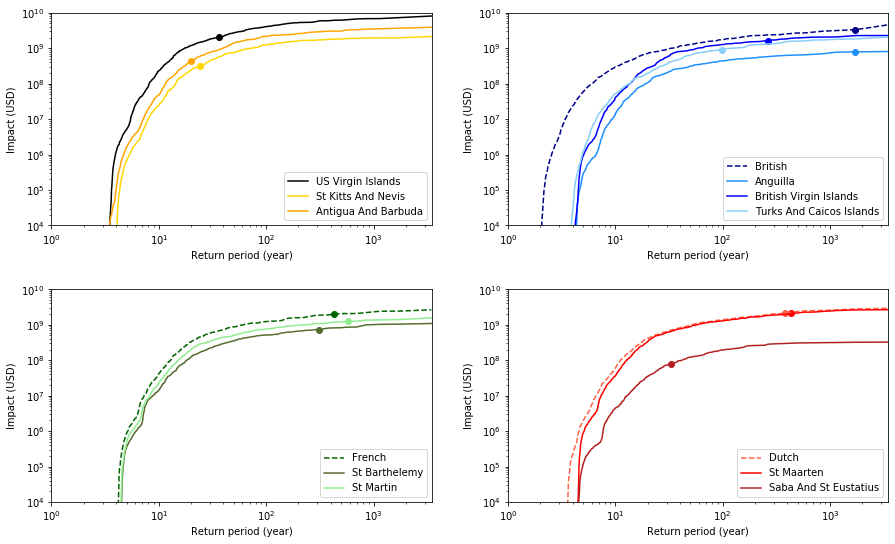

In [3]:
# first paper computations (tracks now include 2018)
%matplotlib inline
from script_risk import calc_impact, calc_tc, calc_tracks, calc_exposure
exp_dict = calc_exposure()
tracks = calc_tracks()
tc_dict = calc_tc(exp_dict, tracks)
imp_dict, imp_fun_ori = calc_impact(exp_dict, tc_dict)

# redo figure first paper
from script_plot_risk import graphs_exceedance
fig, ax = graphs_exceedance(imp_dict)

# ANGUILLA

In [4]:
# 1. define exposure and hazard
exp = exp_dict['AIA']
tc = tc_dict['AIA']

# define time horizon
FUT_YEAR = 2050

# mangroves ha
man_ha = 90

# total areain km2
tot_area = 91

# 2% annual economic growth applied to assets
eg_rate = 2/100
sum_eg_rate = (1-(1+eg_rate)**(FUT_YEAR-exp.ref_year+1))/(1-(1+eg_rate)) # sum of annual economic growth rate

# 1.92% annual population growth
curr_pop = 14764
pop_rate = 1.92/100

# 0.9% rate of urbanization
urb_rate = 0.9/100

In [5]:
# 2. define discount rates
import numpy as np
from climada.entity import DiscRates

disc_rate = DiscRates()
disc_rate.years = np.arange(2016, 2051)
disc_rate.rates = np.ones(disc_rate.years.size)*0.02 # 2% 

## Definition of measures

In [6]:
import copy
from climada.entity import IFTropCyclone

# copy original impact functions
imp_fun = copy.deepcopy(imp_fun_ori)

# define impact function of retrofitting
if_meas = IFTropCyclone()
if_meas.set_emanuel_usa(scale=0.7) # reduction of 0.3
if_meas.name = 'retrofit'
if_meas.id = 2
imp_fun.append(if_meas)

# define impact function of building code
if_meas = IFTropCyclone()
if_meas.set_emanuel_usa(scale=0.6) # reduction of 0.4
if_meas.name = 'building_code'
if_meas.id = 3
imp_fun.append(if_meas)

# define impact function of mangrove coast
if_meas = IFTropCyclone()
if_meas.set_emanuel_usa() # intensity reduction 0.75%
if_meas.name = 'mangrove_coast'
if_meas.id = 4
if_meas.intensity = np.maximum(if_meas.intensity * (1. + min(0.75*(man_ha*0.01/tot_area*100)/100, 3/100)), 0.0)
imp_fun.append(if_meas)

# define impact function of mangrove inland
if_meas = IFTropCyclone()
if_meas.set_emanuel_usa() # intensity reduction 1.5%
if_meas.name = 'mangrove_inland'
if_meas.id = 5
if_meas.intensity = np.maximum(if_meas.intensity * (1. + min(1.5*(man_ha*0.01/tot_area*100)/100, 3/100)), 0.0)
imp_fun.append(if_meas)

In [7]:
# 3. define measures at 2016
import numpy as np
import matplotlib.colors as colors

from climada.entity import Measure, MeasureSet
from climada.util.coordinates import dist_to_coast

from script_adapt import comp_curr_invest_retro

meas_set = MeasureSet()

# set region_id in exposures to filter by region in measures 
exp['dist_coast'] = dist_to_coast(exp.latitude.values, exp.longitude.values)
exp['region_id'] = np.ones(exp.shape[0])   
exp.region_id[exp.dist_coast<500] = 2 # region == coastal assets

# measure 1: retrofitting ret_per of assets
ret_per = 0.10 # ratio of assets value retrofitted this year
meas = Measure()
meas.haz_type = 'TC'
meas.name = 'retrofit'
meas.color_rgb = colors.to_rgb('grey')
# initial investment: ret_per of assets, 10% cost. no maintenance during next years.
meas.cost = exp.value.sum()*0.1*ret_per
# change ret_per assets value to have the new impact function
exp_meas = copy.deepcopy(exp)
exp_meas.value *= 1 - ret_per # 1-ret_per assets value remain the same
exp_meas.if_TC = 1
new_exp = copy.deepcopy(exp)
new_exp.value *= ret_per # ret_per assets value with nnew impact function (retrofitted)
new_exp.if_TC = 2
exp_meas = exp_meas.append([new_exp], ignore_index=True)
meas.exposures_set = exp_meas
meas_set.append(meas)

# measure 2: building code
meas = Measure()
meas.haz_type = 'TC'
meas.name = 'building_code'
meas.color_rgb = colors.to_rgb('indianred')
# 5% cost and urb_rate new buildings in 2016
meas.cost = exp.value.sum()*0.05*urb_rate
exp_meas = copy.deepcopy(exp)
exp_meas.value *= urb_rate # accumulated urban assets
exp_meas.if_TC = 3 # new buildings with building code
new_exp = copy.deepcopy(exp)
new_exp.value *= 1 - urb_rate # assets without building code (no new urban)
exp_meas = exp_meas.append([new_exp], ignore_index=True)
meas.exposures_set = exp_meas
meas_set.append(meas)

# measure 3: mangrove
meas = Measure()
meas.haz_type = 'TC'
meas.name = 'mangrove'
meas.color_rgb = colors.to_rgb('forestgreen')
# initial investment: 100'000 USD/ha
meas.cost = 100000*man_ha 
exp_meas = copy.deepcopy(exp)
exp_meas.if_TC[exp_meas.region_id == 2] = 4
exp_meas.if_TC[exp_meas.region_id == 1] = 5
meas.exposures_set = exp_meas
meas_set.append(meas)

# measure 4: preparedness
meas = Measure()
meas.haz_type = 'TC'
meas.name = 'preparedness'
meas.color_rgb = colors.to_rgb('darkviolet')
# capacity building: initial investment 1$ pro inhabitant + material for preparedness 100$ pro current inhabitat
meas.cost = 100*curr_pop + curr_pop*1
meas.hazard_inten_imp = (1.005, 0)
meas.hazard_freq_cutoff = 1/7
meas_set.append(meas)

# measure 5: risk transfer
meas = Measure()
meas.haz_type = 'TC'
meas.name = 'risk_transfer'
meas.color_rgb = colors.to_rgb('royalblue')
meas.risk_transf_attach = imp_dict['AIA'].calc_freq_curve(12).impact
meas.risk_transf_cover = imp_dict['AIA'].calc_freq_curve(50).impact
meas.risk_transf_cost_factor = 1.5
# cost: only structuring and transaction costs, expected loss will be added to come to total cost of risk transfer
meas.cost = 1000000 + 0.02*meas.risk_transf_cover
meas_set.append(meas)

In [8]:
# 4. define measures at 2050: strategy to achieve goals for 2050

# contain total costs of measures, costs of 2016 are ignored
# same discount rates as defined previously used
meas_set_fut = MeasureSet()

# measure 1: retrofitting ret_per_fut of assets: new percentage of retrofitted houses
ret_per_fut = 0.90 # ratio of assets value retrofitted this year
meas = Measure()
meas.haz_type = 'TC'
meas.name = 'retrofit'
meas.color_rgb = colors.to_rgb('grey')
# initial investment: addition of costs from 2016 until 2050 and discounted 
# 10% cost. no maintenance during next years.
year_per = np.ones(FUT_YEAR-exp.ref_year+1)*(ret_per_fut-ret_per)/(FUT_YEAR-exp.ref_year)
year_per[0] = ret_per # year_per.sum() == ret_per_fut
year_cost = exp.value.sum()*0.1*year_per
meas.cost = disc_rate.net_present_value(exp.ref_year, FUT_YEAR, year_cost)
# change ret_per_fut assets value to have the new impact function
exp_meas = copy.deepcopy(exp)
exp_meas.value *= 1 - ret_per_fut # 1-ret_per_fut assets value remain the same
exp_meas.if_TC = 1
new_exp = copy.deepcopy(exp)
new_exp.value *= ret_per_fut # ret_per_fut assets value with new impact function (retrofitted)
new_exp.if_TC = 2 # impact function retrofitting
exp_meas = exp_meas.append([new_exp], ignore_index=True)
meas.exposures_set = exp_meas
meas_set_fut.append(meas)

# measure 2: building code: total of new building at 2050
meas = Measure()
meas.haz_type = 'TC'
meas.name = 'building_code'
meas.color_rgb = colors.to_rgb('indianred')
# 5% cost and annual urb_rate new buildings and discounted
year_cost = exp.value.sum()*0.05*urb_rate*np.ones(FUT_YEAR-exp.ref_year+1)
meas.cost = disc_rate.net_present_value(exp.ref_year, FUT_YEAR, year_cost)
# in FUT_YEAR accumulated annual 0.9% of value of assets with building code: define new exposures
exp_meas = copy.deepcopy(exp)
exp_meas.value = exp.value.values*urb_rate*(FUT_YEAR-exp.ref_year+1) # accumulated urban assets
exp_meas.if_TC = 3
new_exp = copy.deepcopy(exp)
new_exp.value -= exp_meas.value # assets without building code (no new urban)
new_exp.if_TC = 1
exp_meas = exp_meas.append([new_exp], ignore_index=True)
meas.exposures_set = exp_meas
meas_set_fut.append(meas)

# measure 3: mangrove: add maintenance costs
meas = Measure()
meas.haz_type = 'TC'
meas.name = 'mangrove'
meas.color_rgb = colors.to_rgb('forestgreen')
# initial investment:100'000 USD/ha + 200 USD/ha annual maintenance
year_cost = 200*man_ha*np.ones(FUT_YEAR - exp.ref_year)
meas.cost = 100000*man_ha + disc_rate.net_present_value(exp.ref_year+1, FUT_YEAR, year_cost)
exp_meas = copy.deepcopy(exp)
exp_meas.if_TC[exp_meas.region_id == 2] = 4
exp_meas.if_TC[exp_meas.region_id == 1] = 5
meas.exposures_set = exp_meas
meas_set_fut.append(meas)

# measure 4: preparedness: add maintenance costs
meas = Measure()
meas.haz_type = 'TC'
meas.name = 'preparedness'
meas.color_rgb = colors.to_rgb('darkviolet')
# capacity building: initial investment 1$ pro inhabitant + material for preparedness 100$ pro current inhabitat
# + 0.2$ maintenance annual pro inhabitant
year_cost = np.array([curr_pop*((1+pop_rate)**(year-exp.ref_year)) for year in range(exp.ref_year+1, FUT_YEAR+1)])*0.2
meas.cost = 100*curr_pop + curr_pop*1 + disc_rate.net_present_value(exp.ref_year+1, FUT_YEAR, year_cost)
meas.hazard_inten_imp = (1.005, 0)
meas.hazard_freq_cutoff = 1/7
meas_set_fut.append(meas)

# measure 5: risk transfer: remains the same (cost from risk transfer updated automatically and discounted in cost-benefit computations)
meas = Measure()
meas.haz_type = 'TC'
meas.name = 'risk_transfer'
meas.color_rgb = colors.to_rgb('royalblue')
meas.risk_transf_attach = imp_dict['AIA'].calc_freq_curve(12).impact
meas.risk_transf_cover = imp_dict['AIA'].calc_freq_curve(50).impact
meas.risk_transf_cost_factor = 1.5
# cost: only structuring and transaction costs, expected loss will be added to come to total cost of risk transfer
meas.cost = 1000000 + 0.02*meas.risk_transf_cover
meas_set_fut.append(meas)

2020-12-05 13:13:50,212 - climada.entity.exposures.base - INFO - Matching 395 exposures with 15990 centroids.
2020-12-05 13:13:50,268 - climada.engine.impact - INFO - Calculating damage for 394 assets (>0) and 52900 events.
Emanuel 2011
retrofit
building_code
mangrove_coast
mangrove_inland


Text(0, 0.5, 'Mean damage ratio')

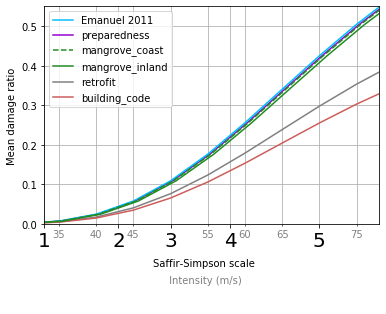

In [9]:
# plot impact functions
import matplotlib.pyplot as plt

fig, axis = plt.subplots()
_, pre_if, _ = meas_set.get_measure('TC', 'preparedness').apply(exp, imp_fun, tc)
axis.plot(pre_if.get_func('TC', 1).intensity, pre_if.get_func('TC', 1).mdd, label='preparedness', color=meas_set.get_measure('TC', 'preparedness').color_rgb)
for i_fun in imp_fun.get_func('TC'):
    ls = '-'
    name = i_fun.name
    print(name)
    if i_fun.id != 4 and i_fun.id != 5 and i_fun.id != 1:
        color = meas_set.get_measure('TC', i_fun.name).color_rgb
    elif i_fun.id == 1:
        color = 'deepskyblue'
    elif i_fun.id == 4:
        ls = '--'
        color = meas_set.get_measure('TC', 'mangrove').color_rgb
    else:
        color = meas_set.get_measure('TC', 'mangrove').color_rgb
    axis.plot(i_fun.intensity, i_fun.mdd, label=name, color=color, ls=ls)

handles, labels = axis.get_legend_handles_labels()
handles = [handles[1], handles[0], handles[-2], handles[-1], handles[2], handles[3]]
labels = [labels[1], labels[0], labels[-2], labels[-1], labels[2], labels[3]]
axis.legend(handles, labels, loc=2)
axis.set_xticks(np.arange(35, 76, 5), minor=True)
axis.set_xticks([33, 43, 50, 58, 70], minor=False)
axis.set_xticklabels(['35', '40', '45', '55', '60', '65', '75'], minor=True, fontdict={'fontsize': 10, 'color':'grey'})
axis.set_xticklabels(['1', '2', '3', '4', '5'], minor=False, fontdict={'fontsize': 20, 'color':'black'})

from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, HPacker
ybox1 = TextArea("Saffir-Simpson scale     ", textprops=dict(color="k", ha='center'))
ybox2 = TextArea("\n \n \n Intensity (m/s)", textprops=dict(color="grey", ha='center'))
ybox = HPacker(children=[ybox1, ybox2], align="center", pad=1, sep=-125, height=-90, width=0)
anchored_ybox = AnchoredOffsetbox(loc=8, child=ybox, pad=0., frameon=False, bbox_transform=2)
axis.add_artist(anchored_ybox)

axis.grid(which='both')
axis.set_xlim(33, 78)
axis.set_ylim(0, 0.55)
axis.set_ylabel('Mean damage ratio')

In [10]:
fig.savefig('fig02.pdf', format='pdf', bbox_inches='tight')

In [11]:
# modify legend to be used later
handles = handles[1:]
labels = labels[1:]
handles = [handles[0], handles[2], handles[4], handles[3], handles[1]]
labels = [labels[0], labels[2], labels[4], labels[3], labels[1]]
labels[-1] = 'risk_transfer'
labels[1] = 'mangrove'
handles[-1].set_color(meas_set.get_measure('TC', 'risk_transfer').color_rgb)
handles[-1].set_ls('-')
for line in handles:
    line.set_linewidth(3.0)

## Moderate Climate Change scenario

In [12]:
# Change in tc intensities according to Knutson et al 2015 for RCP4.5 at FUT_YEAR
fut_tc = tc.set_climate_scenario_knu(ref_year=FUT_YEAR, rcp_scenario=45)

In [13]:
# future exposure
fut_exp = exp.copy()
fut_exp.ref_year = FUT_YEAR
fut_exp.value *= (1+eg_rate)**(fut_exp.ref_year-exp.ref_year)

In [14]:
from climada.entity import Entity

# present and future
# present
ent = Entity()
ent.exposures = exp
ent.impact_funcs = imp_fun
ent.disc_rates = disc_rate
# future
fut_ent = Entity()
fut_ent.exposures = fut_exp # future exposures
fut_ent.impact_funcs = imp_fun # same impact functions
fut_ent.disc_rates = disc_rate

In [15]:
# 5. define measures at 2050: strategy to achieve goals for 2050 with changing exposures
import copy
import numpy as np
import matplotlib.colors as colors

from climada.entity import Measure, MeasureSet, IFTropCyclone
from climada.util.coordinates import dist_to_coast

# contain total costs of measures, costs of 2016 are ignored
# same discount rates as defined previously used
meas_set_cc = MeasureSet()

# measure 1: retrofitting ret_per_fut of assets: new percentage of retrofitted houses
ret_per_fut = 0.90 # ratio of assets value retrofitted this year
meas = Measure()
meas.haz_type = 'TC'
meas.name = 'retrofit'
meas.color_rgb = colors.to_rgb('grey')
# initial investment: addition of costs from 2016 until 2050 and discounted 
# 10% cost. no maintenance during next years.
year_per = np.ones(FUT_YEAR-exp.ref_year+1)*(ret_per_fut-ret_per)/(FUT_YEAR-exp.ref_year)
year_per[0] = ret_per # year_per.sum() == ret_per_fut
year_cost = np.array([exp.value.sum()*((1+eg_rate)**(year-exp.ref_year))*0.1 for year in range(exp.ref_year, fut_exp.ref_year+1)])
year_cost *= year_per
meas.cost = disc_rate.net_present_value(exp.ref_year, FUT_YEAR, year_cost)
# change ret_per_fut assets value to have the new impact function
exp_meas = copy.deepcopy(fut_exp)
exp_meas.value *= 1 - ret_per_fut # 1-ret_per_fut assets value remain the same
exp_meas.if_TC = 1
new_exp = copy.deepcopy(fut_exp)
new_exp.value *= ret_per_fut # ret_per_fut assets value with new impact function (retrofitted)
new_exp.if_TC = 2 # impact function retrofitting
exp_meas = exp_meas.append([new_exp], ignore_index=True)
meas.exposures_set = exp_meas
meas_set_cc.append(meas)

# measure 2: building code: total of new building at 2050
meas = Measure()
meas.haz_type = 'TC'
meas.name = 'building_code'
meas.color_rgb = colors.to_rgb('indianred')
# 5% cost and annual urb_rate new buildings and discounted
year_cost = np.array([exp.value.sum()*((1+eg_rate)**(year-exp.ref_year))*0.05 for year in range(exp.ref_year, fut_exp.ref_year+1)])
year_cost *= urb_rate # every year urb_rate with building code
meas.cost = disc_rate.net_present_value(exp.ref_year, FUT_YEAR, year_cost)
# in FUT_YEAR accumulated annual 0.9% of value of assets with building code: define new exposures
exp_meas = copy.deepcopy(fut_exp)
exp_meas.value = exp.value.values*sum_eg_rate*urb_rate # accumulated urban assets
exp_meas.if_TC = 3
new_exp = copy.deepcopy(fut_exp)
new_exp.value -= exp_meas.value # assets without building code (no new urban)
new_exp.if_TC = 1
exp_meas = exp_meas.append([new_exp], ignore_index=True)
meas.exposures_set = exp_meas
meas_set_cc.append(meas)

# measure 3: mangrove: add maintenance costs
meas = Measure()
meas.haz_type = 'TC'
meas.name = 'mangrove'
meas.color_rgb = colors.to_rgb('forestgreen')
# initial investment:100'000 USD/ha + 200 USD/ha annual maintenance
year_cost = 200*man_ha*np.ones(FUT_YEAR - exp.ref_year)
meas.cost = 100000*man_ha + disc_rate.net_present_value(exp.ref_year+1, FUT_YEAR, year_cost)
exp_meas = copy.deepcopy(fut_exp)
exp_meas.if_TC[exp_meas.region_id == 2] = 4
exp_meas.if_TC[exp_meas.region_id == 1] = 5
meas.exposures_set = exp_meas
meas_set_cc.append(meas)

# measure 4: preparedness: add maintenance costs
meas = Measure()
meas.haz_type = 'TC'
meas.name = 'preparedness'
meas.color_rgb = colors.to_rgb('darkviolet')
# capacity building: initial investment 1$ pro inhabitant + material for preparedness 100$ pro current inhabitat
# + 0.2$ maintenance annual pro inhabitant
year_cost = np.array([curr_pop*((1+pop_rate)**(year-exp.ref_year)) for year in range(exp.ref_year+1, FUT_YEAR+1)])*0.2
meas.cost = 100*curr_pop + curr_pop*1 + disc_rate.net_present_value(exp.ref_year+1, FUT_YEAR, year_cost)
meas.hazard_inten_imp = (1.005, 0)
meas.hazard_freq_cutoff = 1/7 # same measure not as efficient for future events
meas_set_cc.append(meas)

# measure 5: risk transfer: remains the same (cost from risk transfer updated automatically in cost-benefit computations)
meas = Measure()
meas.haz_type = 'TC'
meas.name = 'risk_transfer'
meas.color_rgb = colors.to_rgb('royalblue')
meas.risk_transf_attach = imp_dict['AIA'].calc_freq_curve(12).impact
meas.risk_transf_cover = imp_dict['AIA'].calc_freq_curve(50).impact
meas.risk_transf_cost_factor = 1.5
# cost: only structuring and transaction costs, expected loss will be added to come to total cost of risk transfer
meas.cost = 1000000 + 0.02*meas.risk_transf_cover
meas_set_cc.append(meas)

In [16]:
from climada.engine import CostBenefit, risk_aai_agg

# present and future
# present
ent = Entity()
ent.exposures = exp
ent.impact_funcs = imp_fun
ent.disc_rates = disc_rate
ent.measures = meas_set

# future
fut_ent = Entity()
fut_ent.exposures = fut_exp # future exposures
fut_ent.impact_funcs = imp_fun # same impact functions
fut_ent.disc_rates = disc_rate
fut_ent.measures = meas_set_cc

# changing risk and averted damage with measures
fut_cb = CostBenefit()
fut_cb.calc(tc, ent, fut_tc, fut_ent, risk_func=risk_aai_agg, imp_time_depen=1, save_imp=True)

2020-12-05 13:14:13,873 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:14:13,876 - climada.engine.impact - INFO - Calculating damage for 394 assets (>0) and 52900 events.
2020-12-05 13:14:14,346 - climada.entity.exposures.base - INFO - centr_ not set.
2020-12-05 13:14:14,346 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-05 13:14:14,347 - climada.entity.exposures.base - INFO - cover not set.
2020-12-05 13:14:14,347 - climada.entity.exposures.base - INFO - category_id not set.
2020-12-05 13:14:14,348 - climada.entity.exposures.base - INFO - geometry not set.
2020-12-05 13:14:14,350 - climada.entity.exposures.base - INFO - Matching 790 exposures with 15990 centroids.
2020-12-05 13:14:14,360 - climada.engine.impact - INFO - Calculating damage for 788 assets (>0) and 52900 events.
2020-12-05 13:14:14,720 - climada.entity.exposures.base - INFO - centr_ not set.
2020-12-05 13:14:14,720 - climada.entity.exposures.base - INFO

2020-12-05 13:14:19,108 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:14:19,111 - climada.engine.impact - INFO - Calculating damage for 394 assets (>0) and 52900 events.
2020-12-05 13:14:19,284 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:14:19,285 - climada.engine.impact - INFO - Calculating damage for 394 assets (>0) and 52900 events.
2020-12-05 13:14:19,477 - climada.engine.cost_benefit - INFO - Risk at 2016: 1.806e+07
2020-12-05 13:14:19,478 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:14:19,480 - climada.engine.impact - INFO - Calculating damage for 394 assets (>0) and 52900 events.
2020-12-05 13:14:19,646 - climada.engine.cost_benefit - INFO - Risk with development at 2050: 3.541e+07
2020-12-05 13:14:19,647 - climada.engine.cost_benefit - INFO - Risk with development and climate change at 2050: 4.141e+07


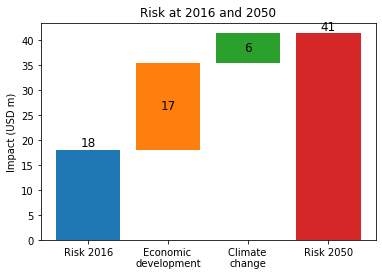

In [17]:
fut_cb.plot_waterfall(tc, ent, fut_tc, fut_ent, risk_func=risk_aai_agg)

In [18]:
# combine adaptation measures mangrove, building_code, preparedness
fut_comb = fut_cb.combine_measures(['mangrove', 'building_code', 'preparedness'], 
                                    'man_bc_prep', colors.to_rgb('darkorange'), ent.disc_rates, risk_func=risk_aai_agg)
fut_comb.apply_risk_transfer('man_bc_prep', meas_set.get_measure('TC', 'risk_transfer').risk_transf_attach, meas_set.get_measure('TC', 'risk_transfer').risk_transf_cover,
                             ent.disc_rates, cost_fix=meas_set.get_measure('TC', 'risk_transfer').cost, 
                             cost_factor=meas_set.get_measure('TC', 'risk_transfer').risk_transf_cost_factor, risk_func=risk_aai_agg)


Measure        Cost (USD m)    Benefit (USD m)    Benefit/Cost
-----------  --------------  -----------------  --------------
man_bc_prep         37.5966            104.352         2.77558

--------------------  --------  -------
Total climate risk:   723.052   (USD m)
Average annual risk:   41.4066  (USD m)
Residual risk:        618.7     (USD m)
--------------------  --------  -------
Net Present Values

Measure                        Cost (USD m)    Benefit (USD m)    Benefit/Cost
---------------------------  --------------  -----------------  --------------
man_bc_prep                         37.5966            104.352        2.77558
risk transfer (man_bc_prep)        553.608             364.224        0.657909

--------------------  --------  -------
Total climate risk:   723.052   (USD m)
Average annual risk:   41.4066  (USD m)
Residual risk:        254.476   (USD m)
--------------------  --------  -------

Risk transfer           Expected damage in     Price (USD m)
           

In [19]:
# now damages of risk transfer and combined measures are additive: benefit = (imp - imp_meas) + (imp_meas - f_tr(imp_meas)) = imp - f_tr(imp_meas)
tot_benefit = fut_comb.benefit['man_bc_prep'] + fut_comb.benefit['risk transfer (man_bc_prep)']
print('Total benefit:', tot_benefit, ',', tot_benefit*100/fut_comb.tot_climate_risk, '%')
tot_cost = fut_comb.cost_ben_ratio['man_bc_prep']*fut_comb.benefit['man_bc_prep'] + \
    fut_comb.cost_ben_ratio['risk transfer (man_bc_prep)']*fut_comb.benefit['risk transfer (man_bc_prep)']
print('Total cost:', tot_cost)
print('Total benefit/cost ratio:', tot_benefit/tot_cost)

Total benefit: 468576212.9044486 , 64.80530063406185 %
Total cost: 591204603.1356862
Total benefit/cost ratio: 0.7925787627822422


2020-12-05 13:14:20,075 - climada.engine.cost_benefit - INFO - Current total risk at 2050: 4.605e+08
2020-12-05 13:14:20,076 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:14:20,078 - climada.engine.impact - INFO - Calculating damage for 394 assets (>0) and 52900 events.
2020-12-05 13:14:20,251 - climada.engine.cost_benefit - INFO - Total risk with development at 2050: 6.556e+08
2020-12-05 13:14:20,252 - climada.engine.cost_benefit - INFO - Total risk with development and climate change at 2050: 7.231e+08


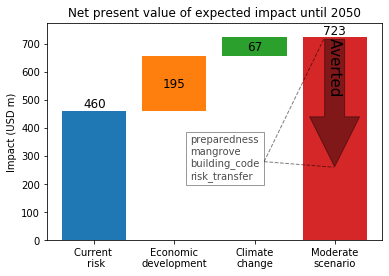

In [20]:
# plot total expected damages
ax = fut_comb.plot_waterfall_accumulated(tc, ent, fut_ent, risk_func=risk_aai_agg)
fut_comb.plot_arrow_averted(ax, in_meas_names=None, accumulate=True) # man_bc_prep and risk transfer (man_bc_prep) benefits are additive, since the second is implemented in a world with man_bc_prep already implemented
ax.set_title('')
ax.set_ylim(0, 775)
ax.set_xticklabels(['Current \n risk', 'Economic\ndevelopment', 'Climate\nchange', 'Moderate\nscenario'])
ax.set_title('Net present value of expected impact until 2050')

from matplotlib.lines import Line2D
textstr = '\n'.join((
    r'preparedness',
    r'mangrove',
    r'building_code',
    r'risk_transfer'))
props = dict(facecolor='white', alpha=0.4)
ax.text(2.2, 220, textstr, bbox=props, alpha=0.7)
dashed_line = Line2D([3.12, 3.87], [280, 720], linestyle = '--', linewidth = 1, color = [0,0,0], zorder = 1, transform = ax.transData, alpha=0.5)
ax.lines.append(dashed_line)
dashed_line = Line2D([3.12, 3.99], [280, 260], linestyle = '--', linewidth = 1, color = [0,0,0], zorder = 1, transform = ax.transData, alpha=0.5)
ax.lines.append(dashed_line)

In [21]:
ax.get_figure().savefig('fig03.pdf', format='pdf', bbox_inches='tight')

## Costs and Benefits

In [22]:
# without changing risk
import matplotlib.ticker as ticker

from climada.entity import Entity
from climada.engine import CostBenefit, risk_aai_agg

ent = Entity()
ent.measures = meas_set
ent.exposures = exp
ent.impact_funcs = imp_fun
ent.disc_rates = disc_rate

ent_fut = Entity()
ent_fut.measures = meas_set_fut # changing measures
ent_fut.exposures = copy.deepcopy(exp) # same exposure
ent_fut.exposures.ref_year = FUT_YEAR # adjust year
ent_fut.impact_funcs = imp_fun # same impact functions
ent_fut.disc_rates = disc_rate

cb_curr = CostBenefit()
cb_curr.calc(tc, ent, ent_future=ent_fut, risk_func=risk_aai_agg, imp_time_depen=1)

2020-12-05 13:14:20,519 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:14:20,521 - climada.engine.impact - INFO - Calculating damage for 394 assets (>0) and 52900 events.
2020-12-05 13:14:20,709 - climada.entity.exposures.base - INFO - centr_ not set.
2020-12-05 13:14:20,710 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-05 13:14:20,710 - climada.entity.exposures.base - INFO - cover not set.
2020-12-05 13:14:20,712 - climada.entity.exposures.base - INFO - category_id not set.
2020-12-05 13:14:20,713 - climada.entity.exposures.base - INFO - geometry not set.
2020-12-05 13:14:20,714 - climada.entity.exposures.base - INFO - Matching 790 exposures with 15990 centroids.
2020-12-05 13:14:20,718 - climada.engine.impact - INFO - Calculating damage for 788 assets (>0) and 52900 events.
2020-12-05 13:14:21,070 - climada.entity.exposures.base - INFO - centr_ not set.
2020-12-05 13:14:21,071 - climada.entity.exposures.base - INFO

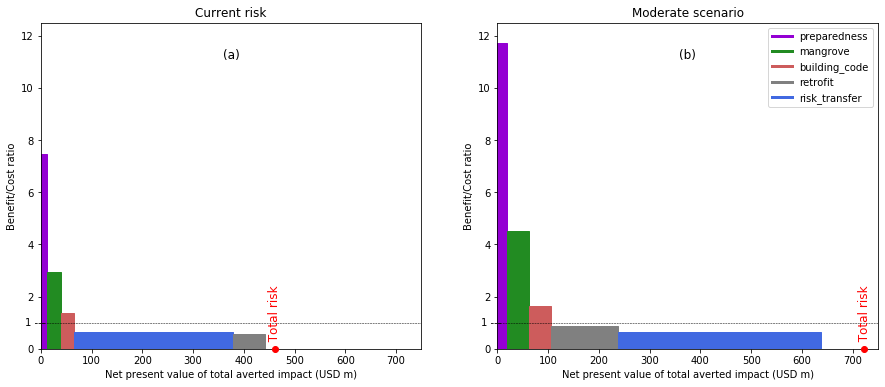

In [23]:
# plot with and without changing future

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

cb_curr.plot_cost_benefit(axis=ax[0])
ax[0].set_title('Current risk')
ax[0].set_ylim(0, 12.5)
ax[0].set_xlim(0, 750)
ax[0].set_xlabel('Net present value of total averted impact (USD m)')
ax[0].text(ax[0].get_xlim()[1]/2, 11., '(a)', horizontalalignment='center', verticalalignment='bottom', fontsize=12, color='k')
ax[0].plot(np.linspace(0, ax[0].get_xlim()[1]), np.ones(np.linspace(0, ax[0].get_xlim()[1]).size), 'k--', lw=0.5)
ax[0].text(-32, 0.9, '1 ---')

fut_cb.plot_cost_benefit(axis=ax[1])
ax[1].set_title('Moderate scenario')
ax[1].set_ylim(0, 12.5)
ax[1].set_xlim(0, 750)
ax[1].set_xlabel('Net present value of total averted impact (USD m)')
ax[1].text(ax[1].get_xlim()[1]/2, 11., '(b)', horizontalalignment='center', verticalalignment='bottom', fontsize=12, color='k')
ax[1].plot(np.linspace(0, ax[1].get_xlim()[1]), np.ones(np.linspace(0, ax[1].get_xlim()[1]).size), 'k--', lw=0.5)
ax[1].text(-32, 0.9, '1 ---')

# remove labels
for i_ax, axis in enumerate(ax):
    for text in axis.texts[:6]:
        text.set_text('')
ax[0].collections[0].remove()
ax[1].collections[0].remove()
ax[0].texts[6].set_text('  Total risk')
ax[1].texts[6].set_text('  Total risk')

# add legend
ax[1].legend(handles, labels)

In [24]:
fig.savefig('fig04.pdf', format='pdf', bbox_inches='tight')

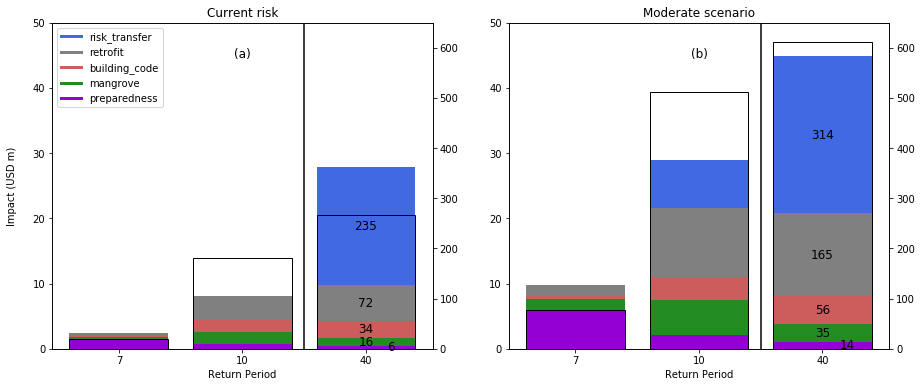

In [25]:
# event view with different scales
from matplotlib.patches import Rectangle

# add numbers
def plot_numbers(axis, i_col, min_bar, max_bar):
    bars = [rect for rect in axis.get_children() if isinstance(rect, Rectangle)]
    for i_bar, bar in enumerate(bars[min_bar:max_bar], min_bar):
        if i_bar < max_bar-1:
            next_bar = bars[i_bar+1].get_height()
        else:
            next_bar = 0
        val = (bar.get_height()-next_bar)
        if i_col == 3 and i_bar == max_bar-1:
            axis.text(i_col+((-1)**i_bar)*0.2, bar.get_height()-(bar.get_height()-next_bar)/2, str(int(round(val))), 
                      horizontalalignment='center', verticalalignment='center', fontsize=12)
        else:
            axis.text(i_col, bar.get_height()-(bar.get_height()-next_bar)/2, str(int(round(val))), 
                       horizontalalignment='center', verticalalignment='center', fontsize=12)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))

rp_sel = (1, 1, 40)

aux_cb = copy.deepcopy(cb_curr.cost_ben_ratio)
cb_curr.cost_ben_ratio['risk_transfer'] = 1/0.5
cb_curr.cost_ben_ratio['retrofit'] = 1/2
cb_curr.cost_ben_ratio['mangrove'] = 1/4
cb_curr.cost_ben_ratio['building_code'] = 1/3
cb_curr.cost_ben_ratio['preparedness'] = 1/5
aux_imp = copy.deepcopy(cb_curr.imp_meas_future)
for meas in cb_curr.imp_meas_future.values():
    meas['efc'].impact /= 1.0e6

# no changing risk
ax[0].set_title('Current risk')
cb_curr.plot_event_view(return_per=rp_sel, axis=ax[0]) 
ax[0].set_xlabel('Return Period')
ax[0].set_ylim(0, 650)
ax[0].get_yaxis().set_major_formatter(ticker.EngFormatter())
ax[0].text(2, 575, '(a)', horizontalalignment='center', verticalalignment='bottom', fontsize=12, color='k')
ax[0].plot([2.5, 2.5], [0, 700], 'k')

ax0 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis
ax[0].yaxis.tick_right()
cb_curr.plot_event_view(return_per=[6.99, 10], axis=ax0)
ax0.get_yaxis().set_major_formatter(ticker.EngFormatter())
ax0.set_ylim(0, 50.0)
ax[0].set_ylabel('Impact (USD m)', labelpad=35)
ax0.set_ylabel('')
ax0.set_xticks([1, 2, 3])
ax0.set_xticklabels(['7', '10', '40'])
ax0.yaxis.tick_left()

# add legend
ax[0].legend(handles[::-1], labels[::-1], loc=2)

# add numbers
plot_numbers(ax[0], 3, 12, 17)

# changing risk
aux_imp_fut = copy.deepcopy(fut_cb.imp_meas_future)
for meas in fut_cb.imp_meas_future.values():
    meas['efc'].impact /= 1.0e6

ax[1].set_title('Moderate scenario')
fut_cb.plot_event_view(return_per=rp_sel, axis=ax[1])
ax[1].set_xlabel('Return Period')
ax[1].set_ylim(0, 650)
ax[1].set_ylabel('')
ax[1].text(2, 575, '(b)', horizontalalignment='center', verticalalignment='bottom', fontsize=12, color='k')
ax[1].plot([2.5, 2.5], [0, 700], 'k')

ax1 = ax[1].twinx()  # instantiate a second axes that shares the same x-axis
ax[1].yaxis.tick_right()
fut_cb.plot_event_view(return_per=[6.99, 10], axis=ax1)
ax1.set_ylim(0, 50.0)
ax1.set_ylabel('')
ax1.set_xticks([1, 2, 3])
ax1.set_xticklabels(['7', '10', '40'])
ax1.yaxis.tick_left()

# add numbers
plot_numbers(ax[1], 3, 12, 17)


cb_curr.cost_ben_ratio = aux_cb
cb_curr.imp_meas_future = aux_imp
fut_cb.imp_meas_future = aux_imp_fut

In [26]:
fig.savefig('fig05.pdf', format='pdf', bbox_inches='tight')

# ANTILLES 
## Moderate Climate Change

In [27]:
# Change in tc intensities according to Knutson et al 2015 for RCP4.5 at FUT_YEAR
fut_tc_dict = dict()
for iso_key, tc in tc_dict.items():
    fut_tc_dict[iso_key] = tc.set_climate_scenario_knu(ref_year=FUT_YEAR, rcp_scenario=45)

In [28]:
# define economic indicators growth
import copy

CNTRIES = ['Saint Barthelemy', 'Saint Martin', 'Sint Maarten', 'Anguilla', \
           'British Virgin Islands', 'United States Virgin Islands', \
           'Turks And Caicos Islands', 'Saint Kitts And Nevis', \
           'Antigua And Barbuda', 'Saba', 'St. Eustatius']

ISO_CNTRIES = ['BLM', 'MAF', 'SXM', 'AIA', 'VGB', 'VIR', 'TCA', 'KNA', 'ATG', 'NLD', 'NLD']

ECONOMY_GROWTH = {'BLM': 2.3, 'MAF': 2.3, 'SXM': 2.1, 'AIA': 2, 'VGB': 2, 'VIR': 2, 'TCA': 3, 'KNA': 3, 'ATG': 2.7, 'NLD': 2}

URB_GROWTH = {'BLM': 1, 'MAF': 1, 'SXM': 1.56, 'AIA': 0.9, 'VGB': 2.42, 'VIR': 0.1, 'TCA': 1.77, 'KNA': 0.92, 'ATG': 0.55, 'NLD': 1}

POPULATION = {'BLM': 9625, 'MAF': 31949, 'SXM': 39969, 'AIA': 14764, 'VGB': 30661, 'VIR': 107510, 'TCA': 34900, 'KNA': 54821, 'ATG': 100963, 'NLD': 5140}

POP_GROWTH = {'BLM': 1, 'MAF': 1, 'SXM': 1.39, 'AIA': 1.92, 'VGB': 2.2, 'VIR': 0, 'TCA': 2.09, 'KNA': 0.7, 'ATG': 1.2, 'NLD': 1}

# area of mangroves in ha
MAN_AREA = {'BLM': 2, 'MAF': 25, 'SXM': 0, 'AIA': 90, 'VGB': 570, 'VIR': 150, 'TCA': 23600, 'KNA': 70, 'ATG': 700, 'NLD': 0}

# total island area
TOT_AREA = {'BLM': 25, 'MAF': 53, 'SXM': 37, 'AIA': 91, 'VGB': 153, 'VIR': 346, 'TCA': 616, 'KNA': 261, 'ATG': 440, 'NLD': 34}

fut_exp_dict = dict()
sum_eg_dict = dict()
for iso_key, exp in exp_dict.items():
    
    fut_exp_dict[iso_key] = copy.deepcopy(exp)
    fut_exp_dict[iso_key].ref_year = FUT_YEAR
    fut_exp_dict[iso_key].value *= (1+ECONOMY_GROWTH[iso_key]/100)**(FUT_YEAR-exp.ref_year)
    
    sum_eg_dict[iso_key] = (1-(1+ECONOMY_GROWTH[iso_key]/100)**(FUT_YEAR-exp.ref_year+1))/(1-(1+ECONOMY_GROWTH[iso_key]/100)) # sum of annual economic growth rate 

2020-12-05 13:19:46,349 - climada.entity.exposures.base - INFO - Matching 122 exposures with 1178 centroids.
2020-12-05 13:19:46,368 - climada.engine.impact - INFO - Calculating damage for 122 assets (>0) and 52900 events.
2020-12-05 13:19:46,527 - climada.entity.exposures.base - INFO - Matching 122 exposures with 1178 centroids.
2020-12-05 13:19:46,531 - climada.engine.impact - INFO - Calculating damage for 122 assets (>0) and 52900 events.
2020-12-05 13:19:46,670 - climada.engine.cost_benefit - INFO - Risk at 2016: 2.070e+07
2020-12-05 13:19:46,672 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:19:46,674 - climada.engine.impact - INFO - Calculating damage for 122 assets (>0) and 52900 events.
2020-12-05 13:19:46,712 - climada.engine.cost_benefit - INFO - Risk with development at 2050: 4.485e+07
2020-12-05 13:19:46,713 - climada.engine.cost_benefit - INFO - Risk with development and climate change at 2050: 5.252e+07
2020-12-05 13:19:46,73

2020-12-05 13:19:54,580 - climada.engine.cost_benefit - INFO - Risk at 2016: 5.019e+07
2020-12-05 13:19:54,581 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:19:54,584 - climada.engine.impact - INFO - Calculating damage for 409 assets (>0) and 52900 events.
2020-12-05 13:19:54,780 - climada.engine.cost_benefit - INFO - Risk with development at 2050: 9.840e+07
2020-12-05 13:19:54,780 - climada.engine.cost_benefit - INFO - Risk with development and climate change at 2050: 1.151e+08
2020-12-05 13:19:54,795 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:19:54,798 - climada.engine.impact - INFO - Calculating damage for 409 assets (>0) and 52900 events.
2020-12-05 13:19:55,028 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:19:55,031 - climada.engine.impact - INFO - Calculating damage for 409 assets (>0) and 52900 events.
2020-12-05 13:19:55,262 - climad

2020-12-05 13:20:14,415 - climada.engine.cost_benefit - INFO - Risk with development and climate change at 2050: 2.230e+08
2020-12-05 13:20:14,432 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:20:14,434 - climada.engine.impact - INFO - Calculating damage for 1793 assets (>0) and 52900 events.
2020-12-05 13:20:14,823 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:20:14,826 - climada.engine.impact - INFO - Calculating damage for 1793 assets (>0) and 52900 events.
2020-12-05 13:20:15,291 - climada.engine.cost_benefit - INFO - Risk at 2016: 2.154e+09
2020-12-05 13:20:15,292 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:20:15,297 - climada.engine.impact - INFO - Calculating damage for 1793 assets (>0) and 52900 events.
2020-12-05 13:20:15,685 - climada.engine.cost_benefit - INFO - Risk with development at 2050: 5.330e+09
2020-12-05 13:20:15,685 - cli

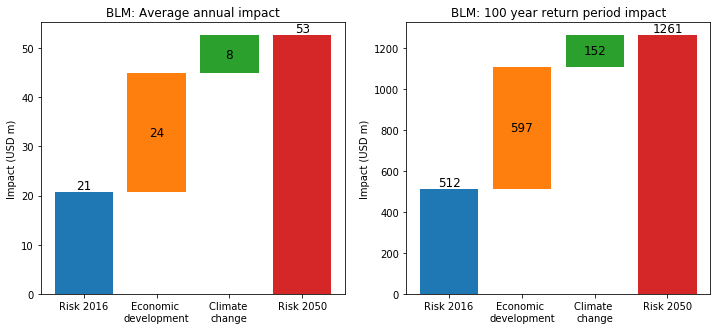

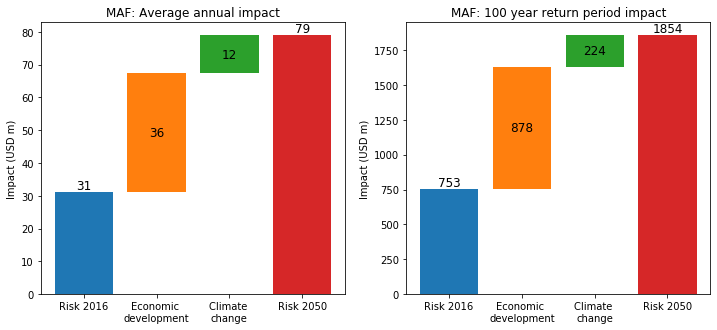

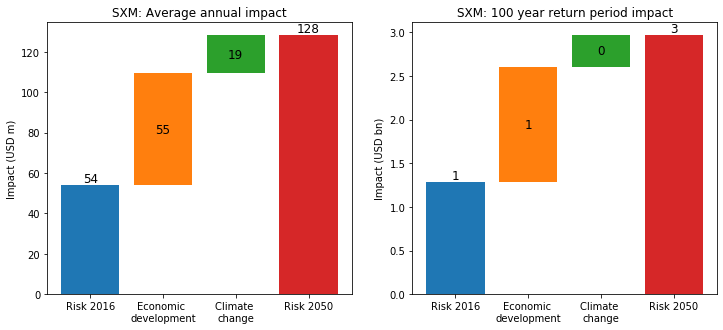

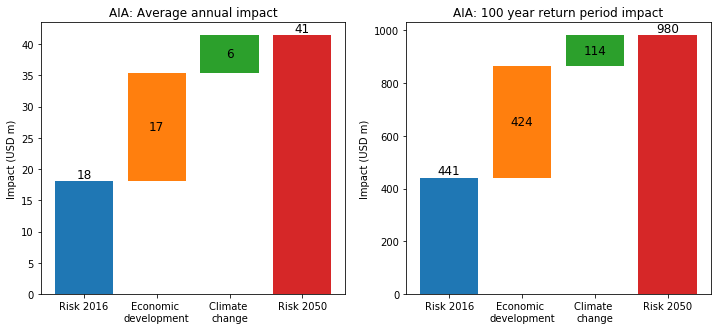

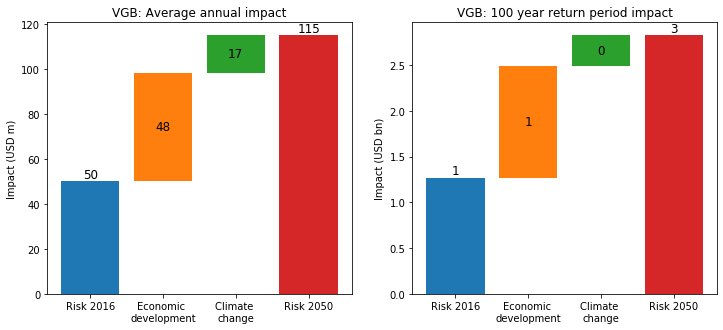

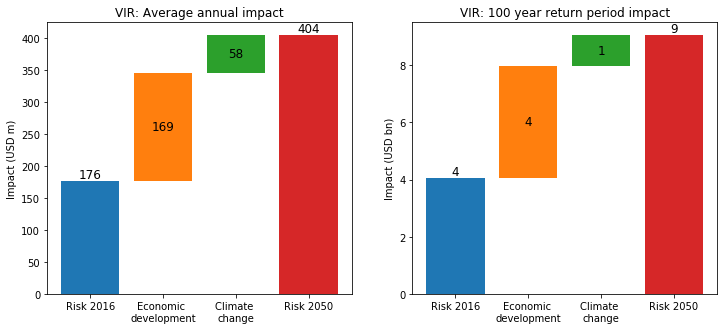

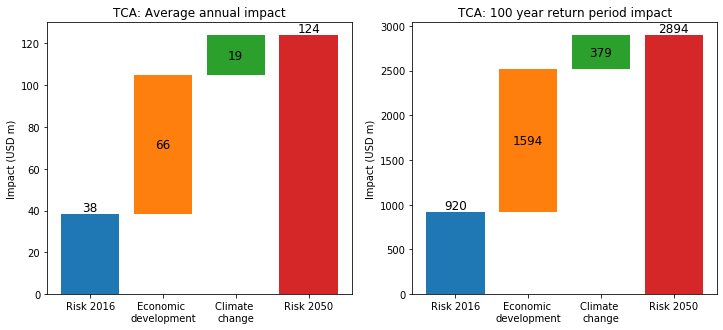

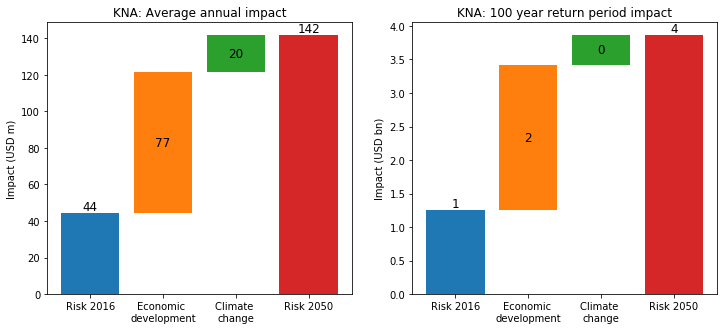

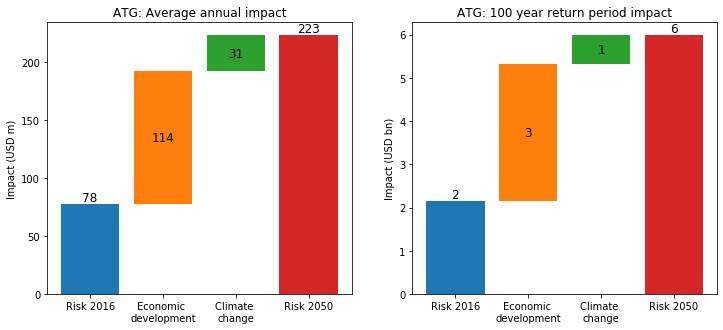

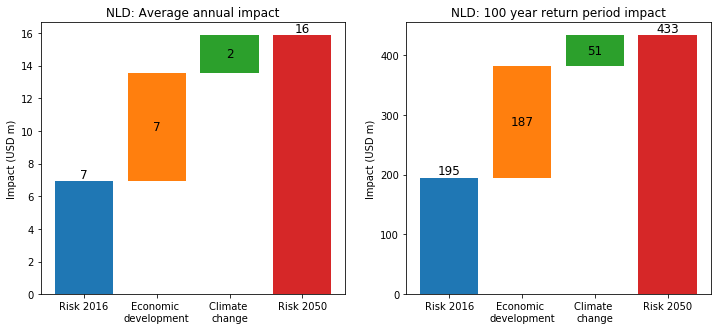

In [29]:
# present and future entities
import matplotlib.pyplot as plt

from climada.entity import Entity
from climada.engine import CostBenefit, risk_aai_agg, risk_rp_100

ent_dict = dict()
fut_ent_dict = dict()
for iso_key in exp_dict.keys():
    ent = Entity()
    ent.exposures = exp_dict[iso_key]
    ent.impact_funcs = imp_fun_ori
    ent.disc_rates = disc_rate
    ent_dict[iso_key] = ent
    
    # future
    fut_ent = Entity()
    fut_ent.exposures = fut_exp_dict[iso_key] # future exposures
    fut_ent.impact_funcs = imp_fun_ori # same impact functions
    fut_ent.disc_rates = disc_rate
    fut_ent_dict[iso_key] = fut_ent

    # risk
    fut_cb = CostBenefit()
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fut_cb.plot_waterfall(tc_dict[iso_key], ent, fut_tc_dict[iso_key], fut_ent, risk_func=risk_aai_agg, axis=ax[0])
    ax[0].set_title(iso_key + ': Average annual impact')
    fut_cb.plot_waterfall(tc_dict[iso_key], ent, fut_tc_dict[iso_key], fut_ent, risk_func=risk_rp_100, axis=ax[1])
    ax[1].set_title(iso_key + ': 100 year return period impact')

## Definition of measures

In [30]:
# impact functions
import copy
from climada.entity import IFTropCyclone

imp_fun_dict = dict()

for iso_key in exp_dict.keys():
    imp_fun_dict[iso_key] = copy.deepcopy(imp_fun_ori)

    # define impact function of retrofitting
    if_meas = IFTropCyclone()
    if_meas.set_emanuel_usa(scale=0.7) # reduction of 0.3
    if_meas.name = 'retrofit'
    if_meas.id = 2
    imp_fun_dict[iso_key].append(if_meas)

    # define impact function of building code
    if_meas = IFTropCyclone()
    if_meas.set_emanuel_usa(scale=0.6) # reduction of 0.4
    if_meas.name = 'building_code'
    if_meas.id = 3
    imp_fun_dict[iso_key].append(if_meas)

    # define impact function of mangrove coast
    if_meas = IFTropCyclone()
    if_meas.set_emanuel_usa()
    if_meas.name = 'mangrove_coast'
    if_meas.id = 4
    if_meas.intensity = np.maximum(if_meas.intensity * (1. + min(0.75*(MAN_AREA[iso_key]*0.01/TOT_AREA[iso_key]*100)/100, 1.5/100)), 0.0)
    imp_fun_dict[iso_key].append(if_meas)

    # define impact function of mangrove inland
    if_meas = IFTropCyclone()
    if_meas.set_emanuel_usa()
    if_meas.name = 'mangrove_inland'
    if_meas.id = 5
    if_meas.intensity = np.maximum(if_meas.intensity * (1. + min(1.5*(MAN_AREA[iso_key]*0.01/TOT_AREA[iso_key]*100)/100, 3/100)), 0.0)
    imp_fun_dict[iso_key].append(if_meas)

    print(iso_key, (1. + min(0.75*(MAN_AREA[iso_key]*0.01/TOT_AREA[iso_key]*100)/100, 1.5/100)), (1. + min(1.5*(MAN_AREA[iso_key]*0.01/TOT_AREA[iso_key]*100)/100, 3/100)))

BLM 1.0006 1.0012
MAF 1.0035377358490567 1.0070754716981132
SXM 1.0 1.0
AIA 1.0074175824175824 1.0148351648351648
VGB 1.015 1.03
VIR 1.0032514450867052 1.0065028901734103
TCA 1.015 1.03
KNA 1.0020114942528735 1.0040229885057472
ATG 1.0119318181818182 1.0238636363636364
NLD 1.0 1.0


In [31]:
# Define measures
# measures at 2016
import matplotlib.colors as colors
from climada.entity import MeasureSet, Measure, IFTropCyclone
from climada.util.coordinates import dist_to_coast

meas_dict = dict()
for iso_key, exp in exp_dict.items():
    
    # set region_id in exposures to filter by region in measures 
    exp['dist_coast'] = dist_to_coast(exp.latitude.values, exp.longitude.values)
    exp['region_id'] = np.ones(exp.shape[0])   
    exp.region_id[exp.dist_coast<500] = 2 # region == coastal assets
    
    meas_set = MeasureSet() # present effect of measure and total measure cost

    # 1. measure: retrofitting everywhere with middle investment
    ret_per = 0.10
    meas = Measure()
    meas.haz_type = 'TC'
    meas.name = 'retrofit'
    meas.color_rgb = colors.to_rgb('grey')
    # 10% cost for ret_per current assets value (initial investment)
    meas.cost = exp.value.sum()*0.1*ret_per
    meas_set.append(meas)
    exp_meas = copy.deepcopy(exp)
    exp_meas.value *= 1 - ret_per # 1-ret_per assets value remain the same
    exp_meas.if_TC = 1
    new_exp = copy.deepcopy(exp)
    new_exp.value *= ret_per # ret_per assets value with nnew impact function (retrofitted)
    new_exp.if_TC = 2
    exp_meas = exp_meas.append([new_exp], ignore_index=True)
    meas.exposures_set = exp_meas
    meas_set.append(meas)
    
    # 3. measure: building code
    meas = Measure()
    meas.haz_type = 'TC'
    meas.name = 'building_code'
    meas.color_rgb = colors.to_rgb('indianred')
    # 5% cost and urb_rate new buildings in 2016
    meas.cost = exp.value.sum()*0.05*URB_GROWTH[iso_key]/100
    exp_meas = copy.deepcopy(exp)
    exp_meas.value *= URB_GROWTH[iso_key]/100 # accumulated urban assets
    exp_meas.if_TC = 3 # new buildings with building code
    new_exp = copy.deepcopy(exp)
    new_exp.value *= 1 - URB_GROWTH[iso_key]/100 # assets without building code (no new urban)
    exp_meas = exp_meas.append([new_exp], ignore_index=True)
    meas.exposures_set = exp_meas
    meas_set.append(meas)

    # 4. measure: mangrove
    meas = Measure()
    meas.haz_type = 'TC'
    meas.name = 'mangrove'
    meas.color_rgb = colors.to_rgb('forestgreen')
    # initial investment: 100'000 USD/ha
    meas.cost = 100000*MAN_AREA[iso_key]
    exp_meas = copy.deepcopy(exp)
    exp_meas.if_TC[exp_meas.region_id == 2] = 4
    exp_meas.if_TC[exp_meas.region_id == 1] = 5
    meas.exposures_set = exp_meas
    meas_set.append(meas)
    
    # 5. measure: preparedness
    meas = Measure()
    meas.haz_type = 'TC'
    meas.name = 'preparedness'
    meas.color_rgb = colors.to_rgb('darkviolet')
    # capacity building: initial investment 1$ pro inhabitant + 0.2$ maintenance annual
    # material for preparedness 100$ pro current inhabitat
    meas.cost = 100*POPULATION[iso_key] + POPULATION[iso_key]*1 
    meas.hazard_inten_imp = (1.005, 0)
    meas.hazard_freq_cutoff = 1/7
    meas_set.append(meas)

    # measure 6: risk transfer
    meas = Measure()
    meas.haz_type = 'TC'
    meas.name = 'risk_transfer'
    meas.color_rgb = colors.to_rgb('royalblue')
    meas.risk_transf_attach = imp_dict[iso_key].calc_freq_curve(12).impact
    meas.risk_transf_cover = imp_dict[iso_key].calc_freq_curve(50).impact
    meas.risk_transf_cost_factor = 1.5
    # cost: only structuring and transaction costs, expected loss will be added to come to total cost of risk transfer
    meas.cost = 1000000 + 0.02*meas.risk_transf_cover
    meas_set.append(meas)

    meas_dict[iso_key] = meas_set

In [32]:
# measures at 2050
meas_dict_fut = dict()
for iso_key, exp in exp_dict.items():

    fut_exp = fut_exp_dict[iso_key]
    fut_exp.region_id = exp.region_id

    meas_set_fut = MeasureSet()

    # measure 1: retrofitting ret_per_fut of assets: new percentage of retrofitted houses
    ret_per_fut = 0.90 # ratio of assets value retrofitted this year
    meas = Measure()
    meas.haz_type = 'TC'
    meas.name = 'retrofit'
    meas.color_rgb = colors.to_rgb('grey')
    # initial investment: addition of costs from 2016 until 2050 and discounted 
    # 10% cost. no maintenance during next years.
    year_per = np.ones(FUT_YEAR-exp.ref_year+1)*(ret_per_fut-ret_per)/(FUT_YEAR-exp.ref_year)
    year_per[0] = ret_per # year_per.sum() == ret_per_fut
    year_cost = np.array([exp.value.sum()*((1+ECONOMY_GROWTH[iso_key]/100)**(year-exp.ref_year))*0.1 for year in range(exp.ref_year, fut_exp.ref_year+1)])
    year_cost *= year_per
    meas.cost = disc_rate.net_present_value(exp.ref_year, FUT_YEAR, year_cost)
    # change ret_per_fut assets value to have the new impact function
    exp_meas = copy.deepcopy(fut_exp)
    exp_meas.value *= 1 - ret_per_fut # 1-ret_per_fut assets value remain the same
    exp_meas.if_TC = 1
    new_exp = copy.deepcopy(fut_exp)
    new_exp.value *= ret_per_fut # ret_per_fut assets value with new impact function (retrofitted)
    new_exp.if_TC = 2 # impact function retrofitting
    exp_meas = exp_meas.append([new_exp], ignore_index=True)
    meas.exposures_set = exp_meas
    meas_set_fut.append(meas)

    # measure 2: building code: total of new building at 2050
    meas = Measure()
    meas.haz_type = 'TC'
    meas.name = 'building_code'
    meas.color_rgb = colors.to_rgb('indianred')
    # 5% cost and annual urb_rate new buildings and discounted
    year_cost = np.array([exp.value.sum()*((1+ECONOMY_GROWTH[iso_key]/100)**(year-exp.ref_year))*0.05 for year in range(exp.ref_year, fut_exp.ref_year+1)])
    year_cost *= URB_GROWTH[iso_key]/100 # every year urb_rate with building code
    meas.cost = disc_rate.net_present_value(exp.ref_year, FUT_YEAR, year_cost)
    # in FUT_YEAR accumulated annual 0.9% of value of assets with building code: define new exposures
    exp_meas = copy.deepcopy(fut_exp)
    exp_meas.value = exp.value.values*sum_eg_dict[iso_key]*URB_GROWTH[iso_key]/100 # accumulated urban assets
    exp_meas.if_TC = 3
    new_exp = copy.deepcopy(fut_exp)
    new_exp.value -= exp_meas.value # assets without building code (no new urban)
    new_exp.if_TC = 1
    exp_meas = exp_meas.append([new_exp], ignore_index=True)
    meas.exposures_set = exp_meas
    meas_set_fut.append(meas)

    # measure 3: mangrove: add maintenance costs
    meas = Measure()
    meas.haz_type = 'TC'
    meas.name = 'mangrove'
    meas.color_rgb = colors.to_rgb('forestgreen')
    # initial investment:100'000 USD/ha + 200 USD/ha annual maintenance
    year_cost = 200*MAN_AREA[iso_key]*np.ones(FUT_YEAR - exp.ref_year)
    meas.cost = 100000*MAN_AREA[iso_key] + disc_rate.net_present_value(exp.ref_year+1, FUT_YEAR, year_cost)
    exp_meas = copy.deepcopy(fut_exp)
    exp_meas.if_TC[exp_meas.region_id == 2] = 4
    exp_meas.if_TC[exp_meas.region_id == 1] = 5
    meas.exposures_set = exp_meas
    meas_set_fut.append(meas)

    # measure 4: preparedness: add maintenance costs
    meas = Measure()
    meas.haz_type = 'TC'
    meas.name = 'preparedness'
    meas.color_rgb = colors.to_rgb('darkviolet')
    # capacity building: initial investment 1$ pro inhabitant + material for preparedness 100$ pro current inhabitat
    # + 0.2$ maintenance annual pro inhabitant
    year_cost = np.array([POPULATION[iso_key]*((1+POP_GROWTH[iso_key]/100)**(year-exp.ref_year)) for year in range(exp.ref_year+1, FUT_YEAR+1)])*0.2
    meas.cost = 100*POPULATION[iso_key] + POPULATION[iso_key]*1 + disc_rate.net_present_value(exp.ref_year+1, FUT_YEAR, year_cost)
    meas.hazard_inten_imp = (1.005, 0)
    meas.hazard_freq_cutoff = 1/7 # same measure not as efficient for future events
    meas_set_fut.append(meas)

    # measure 5: risk transfer: remains the same (cost from risk transfer updated automatically in cost-benefit computations)
    meas = Measure()
    meas.haz_type = 'TC'
    meas.name = 'risk_transfer'
    meas.color_rgb = colors.to_rgb('royalblue')
    meas.risk_transf_attach = imp_dict[iso_key].calc_freq_curve(12).impact
    meas.risk_transf_cover = imp_dict[iso_key].calc_freq_curve(50).impact
    meas.risk_transf_cost_factor = 1.5
    # cost: only structuring and transaction costs, expected loss will be added to come to total cost of risk transfer
    meas.cost = 1000000 + 0.02*meas.risk_transf_cover
    meas_set_fut.append(meas)
    
    meas_dict_fut[iso_key] = meas_set_fut

## Costs and Benefits

In [33]:
cb_dict = dict()
for iso_key in exp_dict.keys():
    print('--------------------------------------' + iso_key + '-----------------------------------------')
    # present
    ent = ent_dict[iso_key]
    ent.measures = meas_dict[iso_key] #present measures
    ent.impact_funcs = imp_fun_dict[iso_key] # updated impact functions

    # future 
    fut_ent = fut_ent_dict[iso_key]
    fut_ent.measures = meas_dict_fut[iso_key] # future measures
    fut_ent.impact_funcs = imp_fun_dict[iso_key] # updated impact functions

    cb = CostBenefit()
    cb.calc(tc_dict[iso_key], ent, fut_tc_dict[iso_key], fut_ent, risk_func=risk_aai_agg, save_imp=True)
    cb_dict[iso_key] = cb

--------------------------------------BLM-----------------------------------------
2020-12-05 13:20:27,594 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:20:27,597 - climada.engine.impact - INFO - Calculating damage for 122 assets (>0) and 52900 events.
2020-12-05 13:20:27,668 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-05 13:20:27,671 - climada.entity.exposures.base - INFO - cover not set.
2020-12-05 13:20:27,683 - climada.entity.exposures.base - INFO - category_id not set.
2020-12-05 13:20:27,691 - climada.entity.exposures.base - INFO - geometry not set.
2020-12-05 13:20:27,705 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:20:27,717 - climada.engine.impact - INFO - Calculating damage for 244 assets (>0) and 52900 events.
2020-12-05 13:20:27,859 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-05 13:20:27,860 - climada.entity.exposures.base - INFO

2020-12-05 13:20:30,102 - climada.engine.impact - INFO - Calculating damage for 335 assets (>0) and 52900 events.
2020-12-05 13:20:30,198 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:20:30,200 - climada.engine.impact - INFO - Calculating damage for 335 assets (>0) and 52900 events.
2020-12-05 13:20:30,357 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:20:30,359 - climada.engine.impact - INFO - Calculating damage for 335 assets (>0) and 52900 events.
2020-12-05 13:20:30,449 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-05 13:20:30,450 - climada.entity.exposures.base - INFO - cover not set.
2020-12-05 13:20:30,450 - climada.entity.exposures.base - INFO - category_id not set.
2020-12-05 13:20:30,451 - climada.entity.exposures.base - INFO - geometry not set.
2020-12-05 13:20:30,452 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 1

2020-12-05 13:20:32,599 - climada.engine.impact - INFO - Calculating damage for 114 assets (>0) and 52900 events.
2020-12-05 13:20:32,824 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:20:32,826 - climada.engine.impact - INFO - Calculating damage for 114 assets (>0) and 52900 events.
2020-12-05 13:20:32,896 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:20:32,897 - climada.engine.impact - INFO - Calculating damage for 114 assets (>0) and 52900 events.
2020-12-05 13:20:33,003 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2016 to 2050.

Measure          Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-------------  ---------------  ------------------  --------------
retrofit             0.494213          0.41201            0.833668
building_code        0.150123          0.23068            1.53661
mangrove             0                 6.13991e-17      inf
preparednes

/Users/aznarsig/Documents/Python/climada_python/climada/engine/cost_benefit.py:876: RuntimeWarning: divide by zero encountered in double_scalars
  1/self.cost_ben_ratio[meas_name]])


2020-12-05 13:20:33,244 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-05 13:20:33,245 - climada.entity.exposures.base - INFO - cover not set.
2020-12-05 13:20:33,246 - climada.entity.exposures.base - INFO - category_id not set.
2020-12-05 13:20:33,247 - climada.entity.exposures.base - INFO - geometry not set.
2020-12-05 13:20:33,249 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:20:33,276 - climada.engine.impact - INFO - Calculating damage for 788 assets (>0) and 52900 events.
2020-12-05 13:20:33,676 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-05 13:20:33,677 - climada.entity.exposures.base - INFO - cover not set.
2020-12-05 13:20:33,678 - climada.entity.exposures.base - INFO - category_id not set.
2020-12-05 13:20:33,679 - climada.entity.exposures.base - INFO - geometry not set.
2020-12-05 13:20:33,681 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05

2020-12-05 13:20:42,417 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:20:42,419 - climada.engine.impact - INFO - Calculating damage for 409 assets (>0) and 52900 events.
2020-12-05 13:20:42,707 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-05 13:20:42,707 - climada.entity.exposures.base - INFO - cover not set.
2020-12-05 13:20:42,708 - climada.entity.exposures.base - INFO - category_id not set.
2020-12-05 13:20:42,709 - climada.entity.exposures.base - INFO - geometry not set.
2020-12-05 13:20:42,711 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:20:42,713 - climada.engine.impact - INFO - Calculating damage for 818 assets (>0) and 52900 events.
2020-12-05 13:20:43,236 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-05 13:20:43,238 - climada.entity.exposures.base - INFO - cover not set.
2020-12-05 13:20:43,241 - climada.entity.exposures.base - INFO - 

2020-12-05 13:20:57,598 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:20:57,600 - climada.engine.impact - INFO - Calculating damage for 1749 assets (>0) and 52900 events.
2020-12-05 13:20:58,170 - climada.engine.cost_benefit - INFO - Computing cost benefit from years 2016 to 2050.

Measure          Cost (USD bn)    Benefit (USD bn)    Benefit/Cost
-------------  ---------------  ------------------  --------------
retrofit             1.69425             1.30243          0.768733
building_code        0.0329438           0.0473575        1.43753
mangrove             0.0157497           0.194228        12.3322
preparedness         0.0113958           0.222701        19.5423
risk_transfer        5.51047             3.63697          0.660011

--------------------  --------  --------
Total climate risk:   7.05736   (USD bn)
Average annual risk:  0.404092  (USD bn)
Residual risk:        1.65367   (USD bn)
--------------------  --------  --------

2020-12-05 13:21:19,417 - climada.engine.impact - INFO - Calculating damage for 2590 assets (>0) and 52900 events.
2020-12-05 13:21:19,946 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-05 13:21:19,947 - climada.entity.exposures.base - INFO - cover not set.
2020-12-05 13:21:19,948 - climada.entity.exposures.base - INFO - category_id not set.
2020-12-05 13:21:19,950 - climada.entity.exposures.base - INFO - geometry not set.
2020-12-05 13:21:19,952 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:21:19,954 - climada.engine.impact - INFO - Calculating damage for 1295 assets (>0) and 52900 events.
2020-12-05 13:21:20,358 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:21:20,359 - climada.engine.impact - INFO - Calculating damage for 1295 assets (>0) and 52900 events.
2020-12-05 13:21:20,959 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-0

2020-12-05 13:21:30,851 - climada.entity.exposures.base - INFO - category_id not set.
2020-12-05 13:21:30,852 - climada.entity.exposures.base - INFO - geometry not set.
2020-12-05 13:21:30,854 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:21:30,856 - climada.engine.impact - INFO - Calculating damage for 3586 assets (>0) and 52900 events.
2020-12-05 13:21:31,676 - climada.entity.exposures.base - INFO - deductible not set.
2020-12-05 13:21:31,677 - climada.entity.exposures.base - INFO - cover not set.
2020-12-05 13:21:31,678 - climada.entity.exposures.base - INFO - category_id not set.
2020-12-05 13:21:31,678 - climada.entity.exposures.base - INFO - geometry not set.
2020-12-05 13:21:31,681 - climada.engine.impact - INFO - Exposures matching centroids found in centr_TC
2020-12-05 13:21:31,684 - climada.engine.impact - INFO - Calculating damage for 1793 assets (>0) and 52900 events.
2020-12-05 13:21:32,350 - climada.engine.impact - INFO - Ex

/Users/aznarsig/Documents/Python/climada_python/climada/engine/cost_benefit.py:779: RuntimeWarning: invalid value encountered in double_scalars
  meas_val['cost'][1]*risk_tr)/meas_ben


----------------> BLM selected measures: ['preparedness', 'mangrove', 'building_code']

Measure      Cost (USD m)    Benefit (USD m)    Benefit/Cost
---------  --------------  -----------------  --------------
combine_3         39.4002            86.3869         2.19255

--------------------  --------  -------
Total climate risk:   885.713   (USD m)
Average annual risk:   52.5212  (USD m)
Residual risk:        799.326   (USD m)
--------------------  --------  -------
Net Present Values

Measure                      Cost (USD m)    Benefit (USD m)    Benefit/Cost
-------------------------  --------------  -----------------  --------------
combine_3                         39.4002            86.3869        2.19255
risk transfer (combine_3)        653.323            430.217         0.658507

--------------------  --------  -------
Total climate risk:   885.713   (USD m)
Average annual risk:   52.5212  (USD m)
Residual risk:        369.109   (USD m)
--------------------  --------  -------



Measure                      Cost (USD m)    Benefit (USD m)    Benefit/Cost
-------------------------  --------------  -----------------  --------------
combine_3                         655.552            673.846        1.02791
risk transfer (combine_3)        1050.02             690.869        0.657956

--------------------  --------  -------
Total climate risk:   1939.55   (USD m)
Average annual risk:   123.83   (USD m)
Residual risk:         574.832  (USD m)
--------------------  --------  -------

Risk transfer           Expected damage in     Price (USD m)
                    insurance layer (USD m)
---------------  --------------------------  ---------------
without measure                     860.857          1305
with measure                        690.869          1050.02

Net Present Values
--------------------------------- 
 Total benefit: 1364715011.3875809
Total cost: 1705575014.1579905
Total benefit/cost ratio: 0.800149509730778 
 --------------------------------------

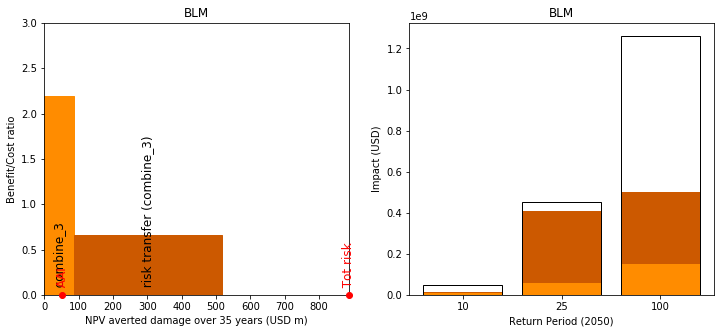

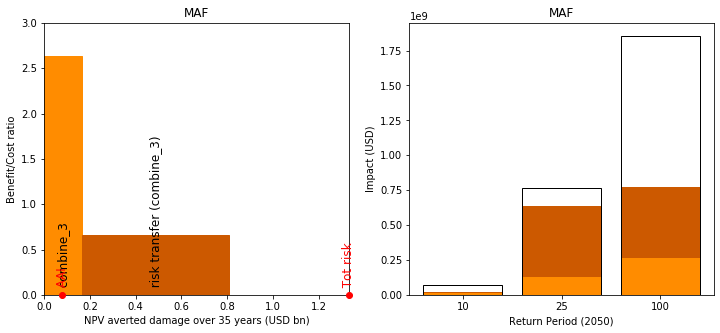

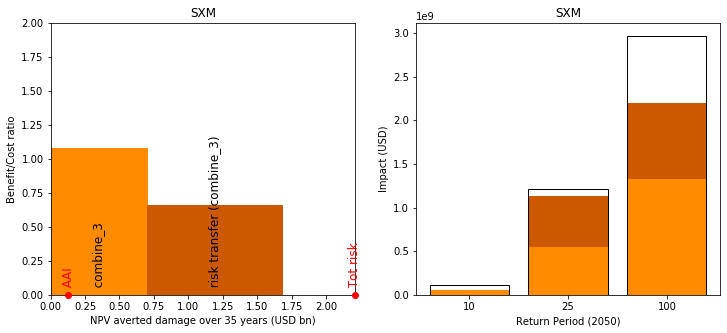

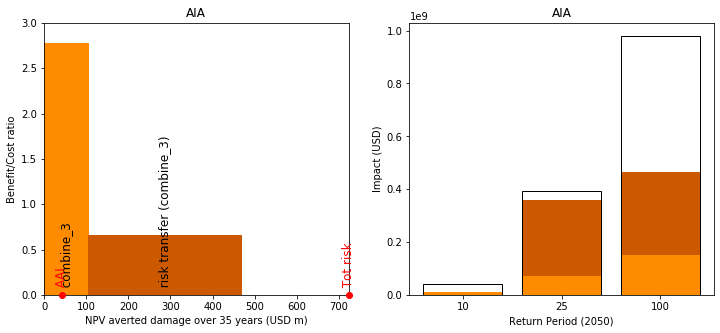

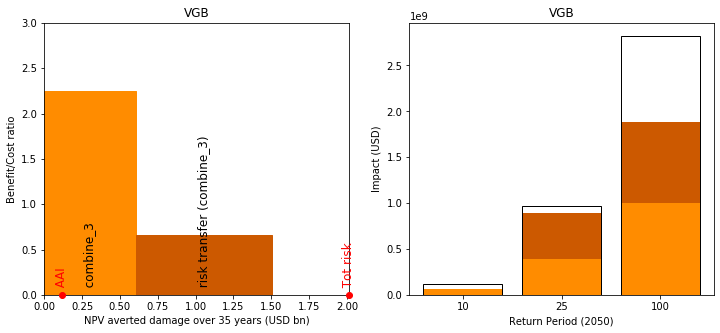

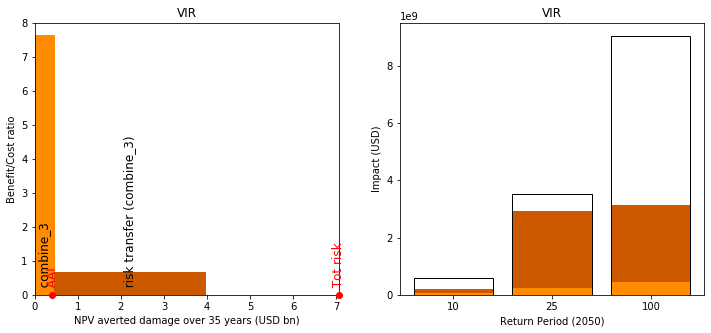

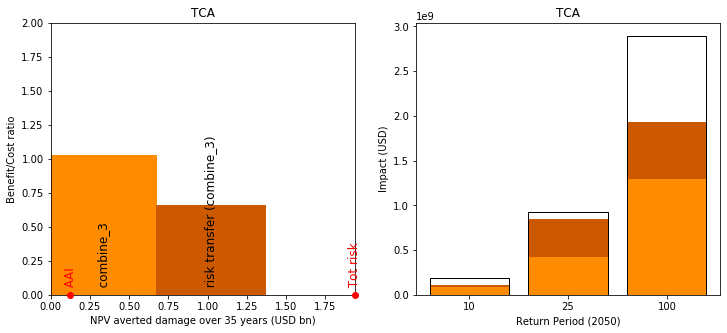

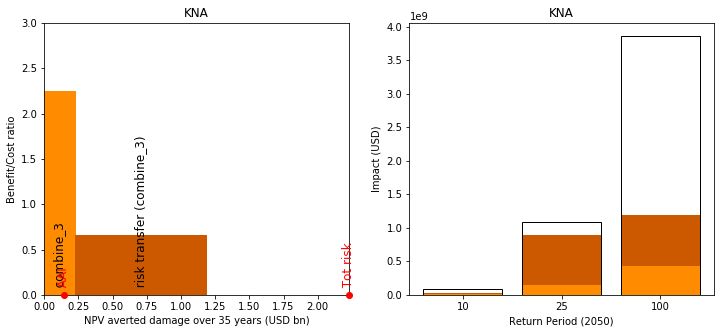

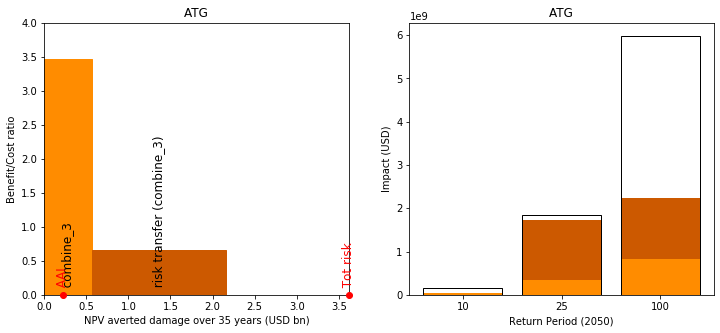

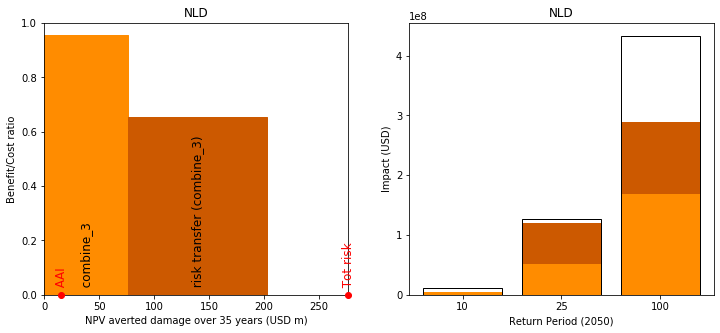

In [34]:
# combine 3 most cost-effective measures
import numpy as np
import matplotlib.colors as colors

per_avert_dict = dict()
per_cb_dict = dict()
sel_meas_dict = dict()
sel_color_dict = dict()
for iso_key, cb in cb_dict.items():

    bc_name = cb.cost_ben_ratio.keys()
    bc_meas = cb.cost_ben_ratio.values()
    sort_arg = np.argsort(np.array(list(bc_meas)))
    sort_meas = np.array(list(bc_name))[sort_arg]
    sel_meas = []
    for meas_name in sort_meas:
        if cb.cost_ben_ratio[meas_name] > 0:
            sel_meas.append(meas_name)
    print('---------------->', iso_key, 'selected measures:', sel_meas[:3])
    
    sel_meas_dict[iso_key] = sel_meas[:3]
    sel_color_dict[iso_key] = [meas_dict[iso_key].get_measure('TC', sel_meas[0]).color_rgb, meas_dict[iso_key].get_measure('TC', sel_meas[1]).color_rgb,
                               meas_dict[iso_key].get_measure('TC', sel_meas[2]).color_rgb]
    cb_comb = cb.combine_measures(sel_meas[:3], 'combine_3', colors.to_rgb('darkorange'), ent.disc_rates, risk_func=risk_aai_agg)
    cb_comb.apply_risk_transfer('combine_3', meas_dict[iso_key].get_measure('TC', 'risk_transfer').risk_transf_attach, 
                                meas_dict[iso_key].get_measure('TC', 'risk_transfer').risk_transf_cover, ent.disc_rates, 
                                cost_fix=1000000+0.02*meas_dict[iso_key].get_measure('TC', 'risk_transfer').risk_transf_cover, 
                                cost_factor=1.5, risk_func=risk_aai_agg)
    
    # here additive: benefit = (imp - imp_meas) + (imp_meas - f_tr(imp_meas)) = imp - f_tr(imp_meas)
    tot_benefit = cb_comb.benefit['combine_3'] + cb_comb.benefit['risk transfer (combine_3)']
    print('--------------------------------- \n Total benefit:', tot_benefit)
    tot_cost = cb_comb.cost_ben_ratio['combine_3']*cb_comb.benefit['combine_3'] + \
        cb_comb.cost_ben_ratio['risk transfer (combine_3)']*cb_comb.benefit['risk transfer (combine_3)']
    print('Total cost:', tot_cost)
    print('Total benefit/cost ratio:', tot_benefit/tot_cost, '\n ------------------------------------------')
    
    per_avert_dict[iso_key] = tot_benefit/cb_comb.tot_climate_risk*100
    per_cb_dict[iso_key] = tot_benefit/tot_cost
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    cb_comb.plot_cost_benefit(axis=ax[0])
    ax[0].set_title(iso_key)

    cb_comb.plot_event_view(axis=ax[1])
    ax[1].set_title(iso_key)

In [35]:
# set results on geopandas DataFrame
import geopandas as gpd
from cartopy.io import shapereader

from climada.util.constants import DEF_CRS
from climada.util.coordinates import get_land_geometry

cntries = ['BLM', 'MAF', 'SXM', 'AIA', 'VGB', 'VIR', 'TCA', 'KNA', 'ATG']
nld_prov = ['Saba', 'St. Eustatius']

list_geom = list()
for isl in cntries:
    list_geom.append(get_land_geometry(isl))

admin1_rec = shapereader.natural_earth(resolution='10m', category='cultural', name='admin_1_states_provinces')
admin1_rec = list(shapereader.Reader(admin1_rec).records())
for rec in admin1_rec:
    for prov in nld_prov:
        if prov == rec.attributes['name'] and rec.attributes['adm0_a3'] == 'NLD':
            list_geom.append(rec.geometry)
            break

df_isl = gpd.GeoDataFrame(crs=DEF_CRS)
df_isl['iso'] = cntries + nld_prov
df_isl['geometry'] = list_geom
df_isl['ben_cost'] = np.zeros(df_isl.shape[0])
df_isl['averted'] = np.zeros(df_isl.shape[0])

for iso_key in cntries:
    df_isl['ben_cost'][df_isl.iso == iso_key] = per_cb_dict[iso_key]
    df_isl['averted'][df_isl.iso == iso_key] = per_avert_dict[iso_key]

df_isl['ben_cost'][df_isl.iso == 'Saba'] = per_cb_dict['NLD']
df_isl['ben_cost'][df_isl.iso == 'St. Eustatius'] = per_cb_dict['NLD']
df_isl['averted'][df_isl.iso == 'Saba'] = per_avert_dict['NLD']
df_isl['averted'][df_isl.iso == 'St. Eustatius'] = per_avert_dict['NLD']

names = list()
for iso in df_isl.iso.values:
    try:
        names.append(CNTRIES[ISO_CNTRIES.index(iso)])
    except ValueError:
        names.append(iso)
    
df_isl['names'] = names
df_isl['centroid'] = df_isl.centroid

In [36]:
# get limits for plot
min_x = df_isl.averted.values.min()
max_x = df_isl.averted.values.max()
delta_x = (max_x-min_x)/3

min_y = df_isl.ben_cost.values.min()
max_y = df_isl.ben_cost.values.max()
delta_y = (max_y-min_y)/3

x_range = [int(min_x), int(round(min_x+delta_x)), int(round(min_x+2*delta_x)), int(round(max_x))]
y_range = [round(min_y, 2), round(min_y+delta_y, 2), round(min_y+2*delta_y, 2), round(max_y, 2)]

In [37]:
# define colormaps
import numpy as np
import matplotlib.pyplot as plt
import colorsys
from matplotlib.colors import ListedColormap

def colorFromBivariateData(z_avert, z_cost, cmap1 = plt.cm.viridis):
    # Assign color depending of averted (color) and beenfit/cost (darker)
    Z_color = np.zeros((z_avert.size, 4))
    for (i_val, val_av), val_cb in zip(enumerate(z_avert), z_cost):
        if val_av < x_range[1]:
            col = np.array(colors.to_rgba('paleturquoise'))
            if val_cb < y_range[1]:
                fact = 0.5
            elif val_cb < y_range[2]:
                fact = 1.0
            else:
                fact = 2.4 # 1.4
        elif val_av < x_range[2]:
            col = np.array(colors.to_rgba('plum'))
            if val_cb < y_range[1]:
                fact = 0.45
            elif val_cb < y_range[2]:
                fact = 1.2
            else:
                fact = 2.4 # 1.15
        else:
            col = np.array(colors.to_rgba('gold'))
            if val_cb < y_range[1]:
                fact = 0.45 # 0.5
            elif val_cb < y_range[2]:
                fact = 1.0
            else:
                fact = 1.4 # 1.5
        c = colorsys.rgb_to_hls(*col[:3])
        Z_color[i_val, :3] = colorsys.hls_to_rgb(c[0], 1 - fact * (1 - c[1]), c[2])
        Z_color[:, -1] = 1

    return Z_color

Z_color = colorFromBivariateData(df_isl['averted'].values, df_isl['ben_cost'].values)
df_isl['color'] = Z_color.tolist()

red_map = ListedColormap(colorFromBivariateData(np.ones(3)*x_range[0], np.array([y_range[0], y_range[1]+0.001, y_range[2]+0.001])))
green_map = ListedColormap(colorFromBivariateData(np.ones(3)*x_range[1]+0.0001, np.array([y_range[0], y_range[1]+0.001, y_range[2]+0.001])))
blue_map = ListedColormap(colorFromBivariateData(np.ones(3)*x_range[2]+0.0001, np.array([y_range[0], y_range[1]+0.001, y_range[2]+0.001])))

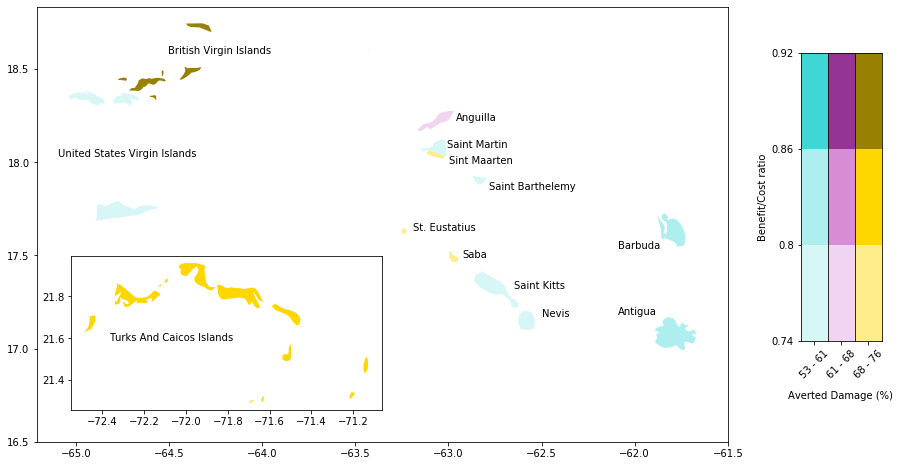

In [38]:
# plot map
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

fig, ax = plt.subplots(1, figsize=(15, 8))

df_1 = df_isl[df_isl.iso != 'TCA']
for i_iso, iso_key in enumerate(df_1.iso):
    df_1[df_1.iso==iso_key].plot(color=df_1[df_1.iso==iso_key].color, ax=ax)
ax.set_ylim(16.5, 18.834092514900057)

rect = [0.05, 0.05, 0.45, 0.4]
box = ax.get_position()
width = box.width
height = box.height
inax_position = ax.transAxes.transform(rect[0:2])
transFigure = fig.transFigure.inverted()
infig_position = transFigure.transform(inax_position)    
x = infig_position[0]
y = infig_position[1]
width *= rect[2]
height *= rect[3]
subax = fig.add_axes([x,y,width,height])
df_isl[df_isl.iso == 'TCA'].plot(color=df_isl[df_isl.iso == 'TCA'].color, ax=subax)


cmap1 = fig.add_axes([0.90, 0.3, 0.025, 0.5])
cmap1.set_ylabel('Benefit/Cost ratio')
cmap1.set_xticks([0.5])
cmap1.set_xticklabels([str(x_range[0]) + ' - ' + str(x_range[1])], rotation=45)
cmap1.set_yticks([0, 0.3333, 0.3333*2, 1])
cmap1.set_yticklabels([str(y_range[0]), str(y_range[1]), str(y_range[2]), str(y_range[3])])

cmap2 = fig.add_axes([0.90+0.025, 0.3, 0.025, 0.5])
cmap2.set_xticks([0.5])
cmap2.set_xticklabels([str(x_range[1]) + ' - ' + str(x_range[2])], rotation=45)
cmap2.set_yticks([])

cmap3 = fig.add_axes([0.90+2*0.025, 0.3, 0.025, 0.5])
cmap3.set_xticks([0.5])
cmap3.set_xticklabels([str(x_range[2]) + ' - ' + str(x_range[3])], rotation=45)
cmap3.set_yticks([])

fig.text(0.9+0.085, 0.2, 'Averted Damage (%)', ha='right')

patches = PatchCollection([Rectangle((0, 0), 1, 0.3333)], facecolor=red_map(0))
cmap1.add_collection(patches)
patches = PatchCollection([Rectangle((0, 0.3333), 1, 0.3333)], facecolor=red_map(1))
cmap1.add_collection(patches)
patches = PatchCollection([Rectangle((0, 0.3333*2), 1, 0.3333)], facecolor=red_map(2))
cmap1.add_collection(patches)

patches = PatchCollection([Rectangle((0, 0), 1, 0.3333)], facecolor=green_map(0))
cmap2.add_collection(patches)
patches = PatchCollection([Rectangle((0, 0.3333), 1, 0.3333)], facecolor=green_map(1))
cmap2.add_collection(patches)
patches = PatchCollection([Rectangle((0, 0.3333*2), 1, 0.3333)], facecolor=green_map(2))
cmap2.add_collection(patches)

patches = PatchCollection([Rectangle((0, 0), 1, 0.3333)], facecolor=blue_map(0))
cmap3.add_collection(patches)
patches = PatchCollection([Rectangle((0, 0.3333), 1, 0.3333)], facecolor=blue_map(1))
cmap3.add_collection(patches)
patches = PatchCollection([Rectangle((0, 0.3333*2), 1, 0.3333)], facecolor=blue_map(2))
cmap3.add_collection(patches)

for i_isl, isl in df_isl.iterrows():
    if isl.iso == 'KNA':
        ax.text(isl.centroid.x+0.05, isl.centroid.y+0.05, 'Saint Kitts')
        
        ax.text(isl.centroid.x+0.2, isl.centroid.y-0.1, 'Nevis')
    elif isl.iso == 'ATG':
        ax.text(isl.centroid.x-0.3, isl.centroid.y+0.25, 'Barbuda')
        ax.text(isl.centroid.x-0.3, isl.centroid.y-0.1, 'Antigua')
    elif isl.iso == 'TCA':
        subax.text(isl.centroid.x+0.1, isl.centroid.y-0.2, isl.names, ha='right', va='bottom')
    elif isl.iso == 'VGB':
        ax.text(isl.centroid.x, isl.centroid.y+0.075, isl.names)
    elif isl.iso == 'VIR':
        ax.text(isl.centroid.x-0.3, isl.centroid.y+0.05, isl.names)
    elif isl.iso == 'AIA':
        ax.text(isl.centroid.x+0.1, isl.centroid.y, isl.names)
    elif isl.iso == 'SXM':
        ax.text(isl.centroid.x+0.075, isl.centroid.y-0.05, isl.names)
    elif isl.iso == 'BLM':
        ax.text(isl.centroid.x+0.05, isl.centroid.y-0.05, isl.names)
    elif isl.iso == 'MAF':
        ax.text(isl.centroid.x+0.05, isl.centroid.y, isl.names)
    elif isl.iso == 'Saba':
        ax.text(isl.centroid.x+0.05, isl.centroid.y, isl.names)
    else:
        ax.text(isl.centroid.x+0.05, isl.centroid.y, isl.names)



In [39]:
fig.savefig('fig06.pdf', format='pdf', bbox_inches='tight')